In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import scipy
import matplotlib.pyplot as plt
import sympy
import scipy.io as sio
from time import perf_counter

In [2]:
from GHKF import GHKF
from EKF import EKF

Imported GHKF
Imported EKF


#### Finding true mean and cov of transformed gaussian

In [3]:
def trueMeanAndCov(m, cov, f, u, f_return_dim, x_dim, dt, for_measurement=False, f_kwargs=None):
    n = 100
    samples = multivariate_normal.rvs(m.flatten(), cov, n)
    transformed_samples = np.array([]).reshape(0, f_return_dim)
    if f_kwargs is None:
        f_kwargs = {}
    for s in samples:
        sample = s.reshape(x_dim, 1)
        if for_measurement: # measurement model does not take u
            transformed = f(sample, **f_kwargs).reshape(1, f_return_dim)
        else:
            transformed = f(sample, u, dt, **f_kwargs).reshape(1, f_return_dim)
        transformed_samples = np.vstack((transformed_samples, transformed))
    result_mean = np.mean(transformed_samples, axis=0)
    result_cov = np.cov(transformed_samples.T)
    return result_mean.reshape(f_return_dim, 1), result_cov.reshape(f_return_dim, f_return_dim)

In [4]:
def f(x, u, dt):
    x1 = x[0, 0]
    x2 = x[1, 0]
    x1_next = x1 + 2*x2
    x2_next = x2 
    return np.array([x1_next, x2_next]).reshape(2, 1)

In [5]:
m = np.array([0, 0]).reshape(2, 1)
cov = np.array([[1, 0.5], 
                [0.5, 1]])
true_m, true_cov = trueMeanAndCov(m, cov, f, u=0, f_return_dim=2, x_dim=2, dt=0.1)
print(true_m)
print(true_cov)

[[0.21643607]
 [0.09090257]]
[[7.34789526 2.57432875]
 [2.57432875 0.98389385]]


#### Pendulum simulation

In [4]:
x1, x2, x3, x4, ksi, w_0, K, Kp, k_e, r, T, u = sympy.symbols(r'x1, x2, x3, x4, \xi, w_0, K, K_p, k_e, r, T, u')
F = sympy.Matrix([x1 + T * x2, 
                  -2 * ksi * w_0 * T * x2 - \
                  w_0**2 * sympy.sin(x1) * T + \
                  Kp * (u - k_e*x3) * T + \
                  x2,
                  K * (u - k_e*x3) * T + x3,
                  x4 + x3 * T])
state = sympy.Matrix([x1, x2, x3, x4])
J = F.jacobian(state)
display(state)
display(F)
display(J)

Matrix([
[x1],
[x2],
[x3],
[x4]])

Matrix([
[                                                   T*x2 + x1],
[K_p*T*(-k_e*x3 + u) - 2*T*\xi*w_0*x2 - T*w_0**2*sin(x1) + x2],
[                                      K*T*(-k_e*x3 + u) + x3],
[                                                   T*x3 + x4]])

Matrix([
[                1,                T,            0, 0],
[-T*w_0**2*cos(x1), -2*T*\xi*w_0 + 1,   -K_p*T*k_e, 0],
[                0,                0, -K*T*k_e + 1, 0],
[                0,                0,            T, 1]])

In [5]:
H = sympy.Matrix([r * sympy.sin(x1),
                  r * sympy.cos(x1)])
state = sympy.Matrix([x1, x2, x3, x4])
J = H.jacobian(state)
display(state)
display(H)
display(J)

Matrix([
[x1],
[x2],
[x3],
[x4]])

Matrix([
[r*sin(x1)],
[r*cos(x1)]])

Matrix([
[ r*cos(x1), 0, 0, 0],
[-r*sin(x1), 0, 0, 0]])

In [39]:
videoPositionsRelative = sio.loadmat('videoPositionsRealRelative.mat')['videoPositionsRelative']
thetas = sio.loadmat('thetasNew.mat')['thetasNew']
us = sio.loadmat('usNew.mat')['usNew']
# Pendulum parameters
ksi_param = 0.03
w_0_param = 2.36
K_param = 529.798
kp_param = -4.3434
k_e = 0.0022
r = 18.0
kwargs = { 'ksi_param': ksi_param, 'w_0_param': w_0_param, 'K_param': K_param, 'kp_param': kp_param, 'k_e': k_e, 'r': r}
Q = np.diag([0, 1, 1, 0])
R = 1*np.eye(2)
m = np.array([0, 0, 0, 0]).reshape(4, 1)
P = np.eye(4)
nsteps = 2000;
p = 3;
dt = 0.033
def f(x, u, dt, **kwargs):
    ksi_param = kwargs['ksi_param']
    w_0_param = kwargs['w_0_param']
    K_param = kwargs['K_param']
    kp_param = kwargs['kp_param']
    k_e = kwargs['k_e']
    x1 = x[0, 0]
    x2 = x[1, 0]
    x3 = x[2, 0]
    x4 = x[3, 0]
    x1_next = x1 + dt * x2
    x2_next = -2 * ksi_param * w_0_param * dt * x2 - \
              w_0_param**2 * np.sin(x1) * dt + \
              kp_param * (u - k_e*x3) * dt + \
              x2
    x3_next = K_param * (u - k_e*x3) * dt + x3
    x4_next = x4 + x3 * dt
    return np.array([x1_next, x2_next, x3_next, x4_next]).reshape(4, 1)
def h(x, **kwargs):
    x1 = x[0, 0]
    r = kwargs['r']
    return np.array([r * np.sin(x1), r * np.cos(x1)]).reshape(2, 1)

In [40]:
def F(x, u, dt, **kwargs):
    ksi = kwargs['ksi_param']
    w_0 = kwargs['w_0_param']
    K = kwargs['K_param']
    kp = kwargs['kp_param']
    k_e = kwargs['k_e']
    x1 = x[0, 0]
    x2 = x[1, 0]
    x3 = x[2, 0]
    x4 = x[3, 0]
    return np.array([[1, dt, 0, 0],
                     [-dt*w_0**2*np.cos(x1), -2*dt*ksi*w_0+1, -kp*dt*k_e, 0],
                     [0, 0, -K*dt*k_e+1, 0],
                     [0, 0, dt, 1]])
def H(x, **kwargs):
    r = kwargs['r']
    x1 = x[0, 0]
    return np.array([[r*np.cos(x1), 0, 0, 0],
                     [-r*np.sin(x1), 0, 0, 0]])

In [41]:
ekf = EKF.ExtendedKalmanFilter(m, P, Q, R, processModel=f, measurementModel=h, F=F, H=H, dt=dt, kwargs=kwargs)
ghkf = GHKF.GH_Kalman_filter(m, P, Q, R, processModel=f, measurementModel=h, degree=p, dt=dt, kwargs=kwargs)

In [42]:
thetas_ekf_predict = [ekf.m[0, 0]]
thetas_ghkf_predict = [ghkf.m[0, 0]]
thetas_ekf = [ekf.m[0, 0]]
thetas_ghkf = [ghkf.m[0, 0]]
ts = [0]
for k in range(1, nsteps):
    u = us[0, k]
    ghkf.predict(u=u)
    ekf.predict(u=u)
    thetas_ekf_predict.append(ekf.m[0, 0])
    thetas_ghkf_predict.append(ghkf.m[0, 0])
    # measurement
    z = videoPositionsRelative[:, k].reshape(2, 1)
    ghkf.update(z)
    ekf.update(z)
    thetas_ekf.append(ekf.m[0, 0])
    thetas_ghkf.append(ghkf.m[0, 0])
    ts.append(k * dt)

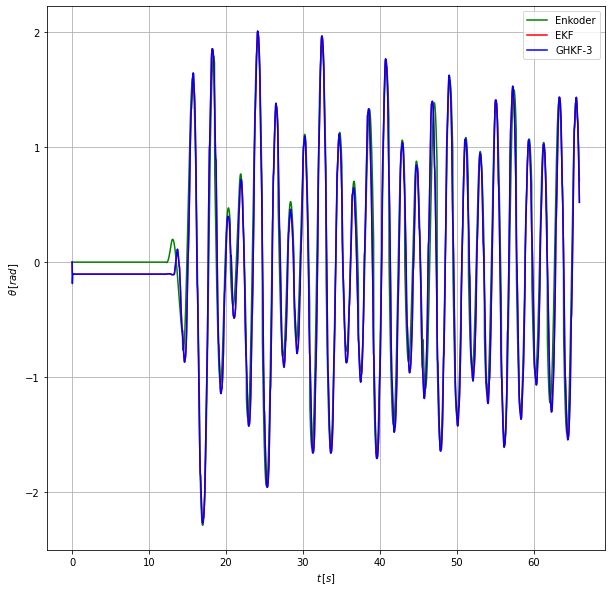

In [47]:
plt.figure(figsize=(10, 10))
thetas_same_size = np.array(thetas[0,:nsteps])
plt.plot(ts, thetas_same_size, 'g-')
plt.plot(ts, thetas_ekf, 'r-')
plt.plot(ts, thetas_ghkf, 'b-')
# plt.plot(ts, thetas_ekf_predict, 'r-')
# plt.plot(ts, thetas_ghkf_predict, 'b-')
plt.legend(['Enkoder', 'EKF', 'GHKF-3'])
plt.xlabel(r'$t\,[s]$')
plt.ylabel(r'$\theta\,[rad]$')
plt.grid()
# plt.savefig('pendulum_results.jpg', bbox_inches='tight')
plt.show()

In [44]:
rmse_ekf = np.sqrt(np.sum((np.array(thetas_ekf) - thetas_same_size)**2 / nsteps))
rmse_ekf

0.237808432328891

In [45]:
rmse_ghkf = np.sqrt(np.sum((np.array(thetas_ghkf) - thetas_same_size)**2 / nsteps))
rmse_ghkf

0.2378313161114599

#### Present functions

In [3]:
def f(x, a):
    return x + a*np.sin(2*x)

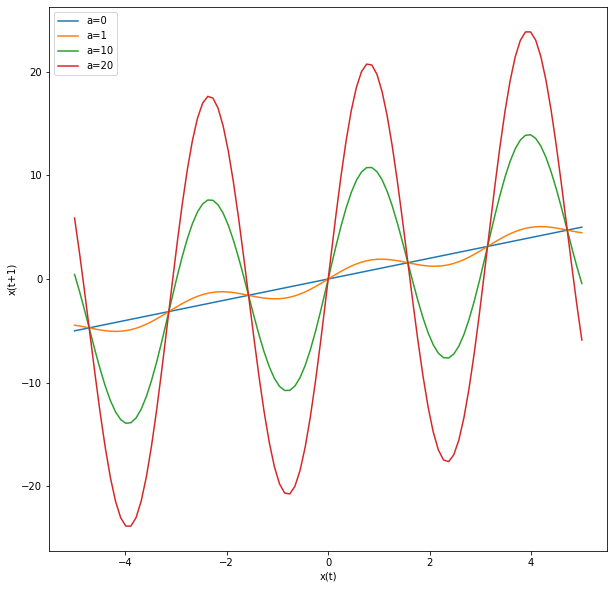

In [13]:
plt.figure(figsize=(10, 10))
t = np.linspace(-5, 5, 100)
plt.plot(t, f(t, 0))
plt.plot(t, f(t, 1))
plt.plot(t, f(t, 10))
plt.plot(t, f(t, 20))
plt.legend(['a=0', 'a=1', 'a=10', 'a=20'])
plt.xlabel('x(t)')
plt.ylabel(r'x(t+1)')
# plt.savefig('rmse_test_functions.jpg', bbox_inches='tight')
plt.show()

In [9]:
ekf = EKF.ExtendedKalmanFilter(m, P, Q, R, processModel=f, measurementModel=h, F=F, H=H, dt=dt)
ghkf = GHKF.GH_Kalman_filter(m, P, Q, R, processModel=f, measurementModel=h, degree=p, dt=dt)

In [33]:
# x = np.random.randn(1).reshape(1, 1)
x = m
x_noisy = x + multivariate_normal.rvs([0], Q).reshape(1, 1)
P_true = P
xs = []
Ps = []
zs = []
ms_ekf = []
ms_ekf_predict = []
ms_ghkf = []
Ps_ekf = []
Ps_ghkf = []
ts = []
for k in range(nsteps):
    u = 0
    ekf.predict(u)
    ms_ekf_predict.append(ekf.m)
    ghkf.predict(u)
    # measurement
#     z = h(x_noisy)
    z, Pz = trueMeanAndCov(x_noisy, P_true, f=h, u=u, f_return_dim=1, x_dim=1, dt=dt, for_measurement=True)
    z_noisy = z + multivariate_normal.rvs([0], R)
    ekf.update(z_noisy)
    ghkf.update(z_noisy)
    xs.append(x_noisy)
    Ps.append(P_true)
    zs.append(z)
    ms_ekf.append(ekf.m)
    ms_ghkf.append(ghkf.m)
    Ps_ekf.append(ekf.P)
    Ps_ghkf.append(ghkf.P)
    ts.append(k * dt)
    # simulation
#     x = f(x, u=0) + G * sqdt * np.random.randn()
    x, P_true = trueMeanAndCov(x_noisy, ghkf.P, f, u=u, f_return_dim=1, x_dim=1, dt=dt)
    x_noisy = x + multivariate_normal.rvs([0], Q).reshape(1, 1)

In [40]:
estimated_positions_ekf = list(map(lambda m: m[0, 0], ms_ekf))
estimated_positions_ghkf = list(map(lambda m: m[0, 0], ms_ghkf))
true_positions = list(map(lambda x: x[0, 0], xs))
measurements = list(map(lambda z: z[0, 0], zs))
# measurements_on_x_axis = np.cbrt(measurements)
measurements_on_x_axis = measurements
Ps_true = list(map(lambda x: x[0, 0], Ps))
estimated_Ps_ekf = list(map(lambda x: x[0, 0], Ps_ekf))
estimated_Ps_ghkf = list(map(lambda x: x[0, 0], Ps_ekf))

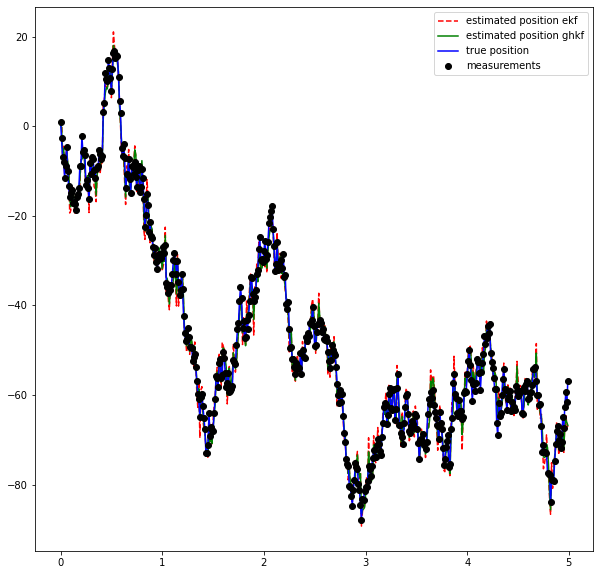

In [41]:
plt.figure(figsize=(10, 10))
plt.plot(ts, estimated_positions_ekf, 'r--')
plt.plot(ts, estimated_positions_ghkf, 'g-')
plt.plot(ts, true_positions, 'b-')
plt.plot(ts, measurements_on_x_axis, 'ko')

# plt.plot(ts, Ps_true, 'm-')
# plt.plot(ts, estimated_Ps_ekf, 'c-')
# plt.plot(ts, estimated_Ps_ghkf, 'y-')

plt.legend(['estimated position ekf', 'estimated position ghkf', 'true position', 'measurements'])
plt.show()

In [42]:
true_positions_array = np.array(true_positions)
error_ekf = np.array(estimated_positions_ekf) - true_positions_array
error_ghkf = np.array(estimated_positions_ghkf) - true_positions_array

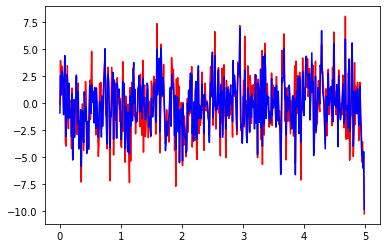

In [43]:
plt.plot(ts, error_ekf, 'r-')
plt.plot(ts, error_ghkf, 'b-')
plt.show()

In [44]:
rmse_ekf = np.sqrt(np.sum((np.array(estimated_positions_ekf) - true_positions_array)**2 / nsteps))
rmse_ekf

2.691650136435307

In [45]:
rmse_ghkf = np.sqrt(np.sum((np.array(estimated_positions_ghkf) - true_positions_array)**2 / nsteps))
rmse_ghkf

2.2941696310736663

#### RMSE as a function of nonlinearity

In [15]:
Q = 10 * np.eye(1)
R = 10 * np.eye(1)
m = np.array([1]).reshape(1, 1)
P = np.array([1]).reshape(1, 1)
monte_carlo_iterations = 100
nsteps = 100
dt = 0.01
def h(x, **kwargs):
    return np.array(x).reshape(1, 1)
def H(x, **kwargs):
    return np.array([1]).reshape(1, 1)
a_values = np.arange(0, 20.5, 1)

EKF:

In [16]:
np.random.seed(2022)
rmse_ekf_values_all = []
times_ekf = []
for a in a_values:
    def f(x, u, dt, **kwargs):
    #     return 0.3*x + u
    #     return np.sin(x) + u
    #     return 0.01*x*x + u
        return x + kwargs['a']*np.sin(2*x)
    def F(x, u, dt, **kwargs):
    #     return np.array([0.3]).reshape(1, 1)
    #     return np.cos(x)
    #     return 0.01*2*x
        return 1 + kwargs['a']*np.cos(2*x)*2
    kwargs = {'a': a}
    rmses_for_a = []
    for i in range(monte_carlo_iterations):
        ekf = EKF.ExtendedKalmanFilter(m, P, Q, R, processModel=f, measurementModel=h, F=F, H=H, dt=dt, kwargs=kwargs)
        x = m
        x_noisy = x + multivariate_normal.rvs([0], Q).reshape(1, 1)
        P_true = P
        xs = []
        Ps = []
        zs = []
        estimated_positions_ekf = []
        ts = []
        t_start = perf_counter()
        for k in range(nsteps):
            u = 0
            ekf.predict(u)
            # measurement
        #     z = h(x_noisy)
            z, Pz = trueMeanAndCov(x_noisy, P_true, f=h, u=u, f_return_dim=1, x_dim=1, 
                                   dt=dt, for_measurement=True)
            z_noisy = z + multivariate_normal.rvs([0], R).reshape(1, 1)
            ekf.update(z_noisy)
            xs.append(x_noisy[0, 0])
            estimated_positions_ekf.append(ekf.m[0, 0])
            ts.append(k * dt)
            # simulation
        #     x = f(x, u=0) + G * sqdt * np.random.randn()
            x, P_true = trueMeanAndCov(x_noisy, ekf.P, f, u=u, f_return_dim=1, x_dim=1, dt=dt,
                                      f_kwargs=kwargs)
            x_noisy = x + multivariate_normal.rvs([0], Q).reshape(1, 1)   
        t_stop = perf_counter()
        times_ekf.append(t_stop - t_start)
        true_positions_array = np.array(xs)
        rmse_ekf = np.sqrt(np.sum((np.array(estimated_positions_ekf) - true_positions_array)**2 / nsteps))
        rmses_for_a.append(rmse_ekf)
    rmse_ekf_values_all.append(np.mean(rmses_for_a))
    print(f"a={a}", end=" ")

a=0.0 a=1.0 a=2.0 a=3.0 a=4.0 a=5.0 a=6.0 a=7.0 a=8.0 a=9.0 a=10.0 a=11.0 a=12.0 a=13.0 a=14.0 a=15.0 a=16.0 a=17.0 a=18.0 a=19.0 a=20.0 

In [17]:
np.mean(times_ekf)

0.3351892888571525

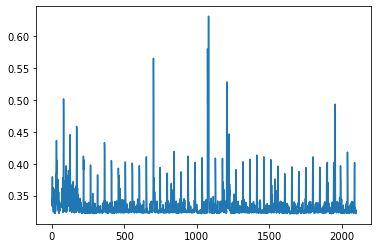

In [18]:
plt.plot(times_ekf)
plt.show()

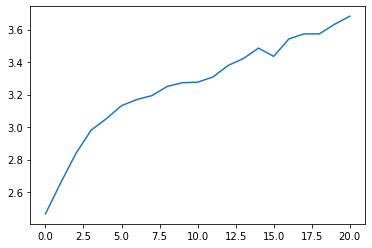

In [19]:
plt.plot(a_values, rmse_ekf_values_all)
plt.show()

In [19]:
np.save('rmses_ekf.npy', rmse_ekf_values_all)

GHKF-2:

In [20]:
np.random.seed(2022)
rmse_ghkf2_values_all = []
times_ghkf2 = []
for a in a_values:
    def f(x, u, dt, **kwargs):
    #     return 0.3*x + u
    #     return np.sin(x) + u
    #     return 0.01*x*x + u
        return x + kwargs['a']*np.sin(2*x)
    def F(x, u, dt, **kwargs):
    #     return np.array([0.3]).reshape(1, 1)
    #     return np.cos(x)
    #     return 0.01*2*x
        return 1 + kwargs['a']*np.cos(2*x)*2
    kwargs = {'a': a}
    rmses_for_a = []
    for i in range(monte_carlo_iterations):
        ghkf2 = GHKF.GH_Kalman_filter(m, P, Q, R, processModel=f, measurementModel=h, degree=2, dt=dt, kwargs=kwargs)
        x = m
        x_noisy = x + multivariate_normal.rvs([0], Q).reshape(1, 1)
        P_true = P
        xs = []
        Ps = []
        zs = []
        estimated_positions_ghkf2 = []
        ts = []
        t_start = perf_counter()
        for k in range(nsteps):
            u = 0
            ghkf2.predict(u)
            # measurement
        #     z = h(x_noisy)
            z, Pz = trueMeanAndCov(x_noisy, P_true, f=h, u=u, f_return_dim=1, x_dim=1, 
                                   dt=dt, for_measurement=True)
            z_noisy = z + multivariate_normal.rvs([0], R).reshape(1, 1)
            ghkf2.update(z_noisy)
            xs.append(x_noisy[0, 0])
            estimated_positions_ghkf2.append(ghkf2.m[0, 0])
            ts.append(k * dt)
            # simulation
        #     x = f(x, u=0) + G * sqdt * np.random.randn()
            x, P_true = trueMeanAndCov(x_noisy, ghkf2.P, f, u=u, f_return_dim=1, x_dim=1, dt=dt,
                                      f_kwargs=kwargs)
            x_noisy = x + multivariate_normal.rvs([0], Q).reshape(1, 1)   
        t_stop = perf_counter()
        times_ghkf2.append(t_stop - t_start)
        true_positions_array = np.array(xs)
        rmse_ghkf2 = np.sqrt(np.sum((np.array(estimated_positions_ghkf2) - true_positions_array)**2 / nsteps))
        rmses_for_a.append(rmse_ghkf2)
    rmse_ghkf2_values_all.append(np.mean(rmses_for_a))
    print(f"a={a}", end=" ")

a=0.0 a=1.0 a=2.0 a=3.0 a=4.0 a=5.0 a=6.0 a=7.0 a=8.0 a=9.0 a=10.0 a=11.0 a=12.0 a=13.0 a=14.0 a=15.0 a=16.0 a=17.0 a=18.0 a=19.0 a=20.0 

In [21]:
np.mean(times_ghkf2)

0.349760048857142

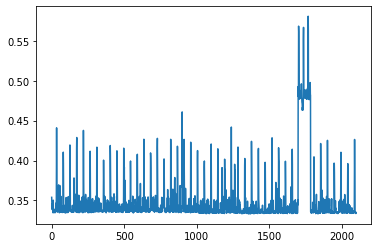

In [22]:
plt.plot(times_ghkf2)
plt.show()

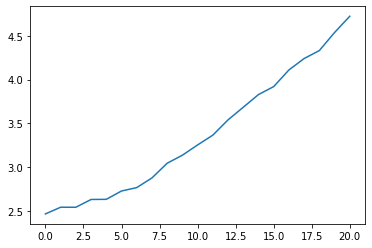

In [23]:
plt.plot(a_values, rmse_ghkf2_values_all)
plt.show()

In [34]:
np.save('rmses_ghkf2.npy', rmse_ghkf2_values_all)

GHKF-3:

In [24]:
np.random.seed(2022)
rmse_ghkf3_values_all = []
times_ghkf3 = []
for a in a_values:
    def f(x, u, dt, **kwargs):
    #     return 0.3*x + u
    #     return np.sin(x) + u
    #     return 0.01*x*x + u
        return x + kwargs['a']*np.sin(2*x)
    def F(x, u, dt, **kwargs):
    #     return np.array([0.3]).reshape(1, 1)
    #     return np.cos(x)
    #     return 0.01*2*x
        return 1 + kwargs['a']*np.cos(2*x)*2
    kwargs = {'a': a}
    rmses_for_a = []
    for i in range(monte_carlo_iterations):
        ghkf3 = GHKF.GH_Kalman_filter(m, P, Q, R, processModel=f, measurementModel=h, degree=3, dt=dt, kwargs=kwargs)
        x = m
        x_noisy = x + multivariate_normal.rvs([0], Q).reshape(1, 1)
        P_true = P
        xs = []
        Ps = []
        zs = []
        estimated_positions_ghkf3 = []
        ts = []
        t_start = perf_counter()
        for k in range(nsteps):
            u = 0
            ghkf3.predict(u)
            # measurement
        #     z = h(x_noisy)
            z, Pz = trueMeanAndCov(x_noisy, P_true, f=h, u=u, f_return_dim=1, x_dim=1, 
                                   dt=dt, for_measurement=True)
            z_noisy = z + multivariate_normal.rvs([0], R).reshape(1, 1)
            ghkf3.update(z_noisy)
            xs.append(x_noisy[0, 0])
            estimated_positions_ghkf3.append(ghkf3.m[0, 0])
            ts.append(k * dt)
            # simulation
        #     x = f(x, u=0) + G * sqdt * np.random.randn()
            x, P_true = trueMeanAndCov(x_noisy, ghkf3.P, f, u=u, f_return_dim=1, x_dim=1, dt=dt,
                                      f_kwargs=kwargs)
            x_noisy = x + multivariate_normal.rvs([0], Q).reshape(1, 1)   
        t_stop = perf_counter()
        times_ghkf3.append(t_stop - t_start)
        true_positions_array = np.array(xs)
        rmse_ghkf3 = np.sqrt(np.sum((np.array(estimated_positions_ghkf3) - true_positions_array)**2 / nsteps))
        rmses_for_a.append(rmse_ghkf3)
    rmse_ghkf3_values_all.append(np.mean(rmses_for_a))
    print(f"a={a}", end=" ")

a=0.0 a=1.0 a=2.0 a=3.0 a=4.0 a=5.0 a=6.0 a=7.0 a=8.0 a=9.0 a=10.0 a=11.0 a=12.0 a=13.0 a=14.0 a=15.0 a=16.0 a=17.0 a=18.0 a=19.0 a=20.0 

In [25]:
np.mean(times_ghkf3)

0.3487965110952367

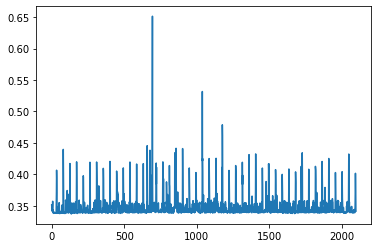

In [26]:
plt.plot(times_ghkf3)
plt.show()

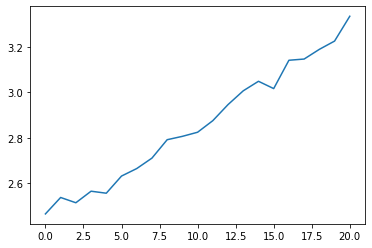

In [27]:
plt.plot(a_values, rmse_ghkf3_values_all)
plt.show()

In [39]:
np.save('rmses_ghkf3.npy', rmse_ghkf3_values_all)

GHKF-5:

In [28]:
np.random.seed(2022)
rmse_ghkf5_values_all = []
times_ghkf5 = []
for a in a_values:
    def f(x, u, dt, **kwargs):
    #     return 0.3*x + u
    #     return np.sin(x) + u
    #     return 0.01*x*x + u
        return x + kwargs['a']*np.sin(2*x)
    def F(x, u, dt, **kwargs):
    #     return np.array([0.3]).reshape(1, 1)
    #     return np.cos(x)
    #     return 0.01*2*x
        return 1 + kwargs['a']*np.cos(2*x)*2
    kwargs = {'a': a}
    rmses_for_a = []
    for i in range(monte_carlo_iterations):
        ghkf5 = GHKF.GH_Kalman_filter(m, P, Q, R, processModel=f, measurementModel=h, degree=5, dt=dt, kwargs=kwargs)
        x = m
        x_noisy = x + multivariate_normal.rvs([0], Q).reshape(1, 1)
        P_true = P
        xs = []
        Ps = []
        zs = []
        estimated_positions_ghkf5 = []
        ts = []
        t_start = perf_counter()
        for k in range(nsteps):
            u = 0
            ghkf5.predict(u)
            # measurement
        #     z = h(x_noisy)
            z, Pz = trueMeanAndCov(x_noisy, P_true, f=h, u=u, f_return_dim=1, x_dim=1, 
                                   dt=dt, for_measurement=True)
            z_noisy = z + multivariate_normal.rvs([0], R).reshape(1, 1)
            ghkf5.update(z_noisy)
            xs.append(x_noisy[0, 0])
            estimated_positions_ghkf5.append(ghkf5.m[0, 0])
            ts.append(k * dt)
            # simulation
        #     x = f(x, u=0) + G * sqdt * np.random.randn()
            x, P_true = trueMeanAndCov(x_noisy, ghkf5.P, f, u=u, f_return_dim=1, x_dim=1, dt=dt,
                                      f_kwargs=kwargs)
            x_noisy = x + multivariate_normal.rvs([0], Q).reshape(1, 1)   
        t_stop = perf_counter()
        times_ghkf5.append(t_stop - t_start)
        true_positions_array = np.array(xs)
        rmse_ghkf5 = np.sqrt(np.sum((np.array(estimated_positions_ghkf5) - true_positions_array)**2 / nsteps))
        rmses_for_a.append(rmse_ghkf5)
    rmse_ghkf5_values_all.append(np.mean(rmses_for_a))
    print(f"a={a}", end=" ")

a=0.0 a=1.0 a=2.0 a=3.0 a=4.0 a=5.0 a=6.0 a=7.0 a=8.0 a=9.0 a=10.0 a=11.0 a=12.0 a=13.0 a=14.0 a=15.0 a=16.0 a=17.0 a=18.0 a=19.0 a=20.0 

In [29]:
np.mean(times_ghkf5)

0.3579594770952497

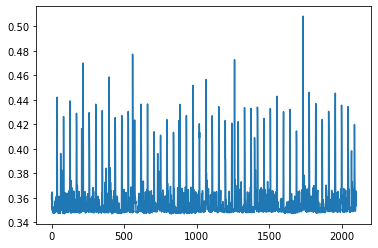

In [30]:
plt.plot(times_ghkf5)
plt.show()

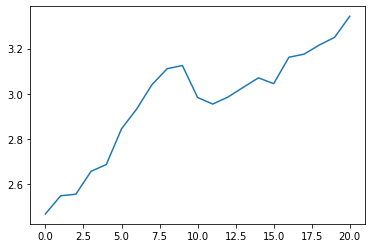

In [31]:
plt.plot(a_values, rmse_ghkf5_values_all)
plt.show()

In [44]:
np.save('rmses_ghkf5.npy', rmse_ghkf5_values_all)

In [32]:
np.min(times_ekf)

0.3212428999995609

In [33]:
np.min(times_ghkf2)

0.33312839999962307

In [34]:
np.min(times_ghkf3)

0.33722469999975146

In [35]:
np.min(times_ghkf5)

0.34699469999941357

All on 1 plot:

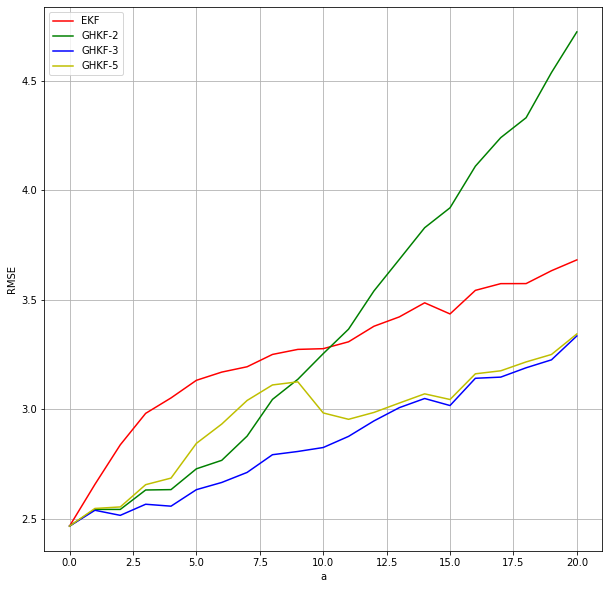

In [37]:
plt.figure(figsize=(10, 10))
mark = '-'
plt.plot(a_values, rmse_ekf_values_all, f'r{mark}')
plt.plot(a_values, rmse_ghkf2_values_all, f'g{mark}')
plt.plot(a_values, rmse_ghkf3_values_all, f'b{mark}')
plt.plot(a_values, rmse_ghkf5_values_all, f'y{mark}')
plt.legend(['EKF', 'GHKF-2', 'GHKF-3', 'GHKF-5'])
plt.xlabel('a')
plt.ylabel('RMSE')
plt.grid()
plt.savefig('rmse_test_results.jpg', bbox_inches='tight')
plt.show()

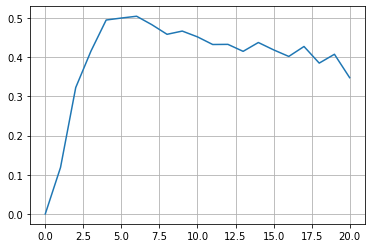

In [41]:
plt.plot(a_values, np.array(rmse_ekf_values_all) - np.array(rmse_ghkf3_values_all))
plt.grid()
plt.show()

In [10]:
np.random.seed(2022)
Q = 10 * np.eye(1)
R = 10 * np.eye(1)
m = np.array([1]).reshape(1, 1)
P = np.array([1]).reshape(1, 1)
# z = np.array([0]).reshape(1, 1)
nsteps = 500
p = 3
dt = 0.01
def h(x):
    return np.array(x).reshape(1, 1)
def H(x):
    return np.array([1]).reshape(1, 1)
a_values = np.arange(0, 20.5, 0.5)
rmse_ekf_values = []
rmse_ghkf_values = []
for a in a_values:
    def f(x, u, dt, **kwargs):
    #     return 0.3*x + u
    #     return np.sin(x) + u
    #     return 0.01*x*x + u
        return x + kwargs['a']*np.sin(2*x)
    def F(x, u, dt, **kwargs):
    #     return np.array([0.3]).reshape(1, 1)
    #     return np.cos(x)
    #     return 0.01*2*x
        return 1 + kwargs['a']*np.cos(2*x)*2
    processModelkwargs = {'a': a}
    Fkwargs = {'a': a}
    ekf = EKF.ExtendedKalmanFilter(m, P, Q, R, processModel=f, measurementModel=h, F=F, H=H, dt=dt, 
                                   processModelkwargs=processModelkwargs, Fkwargs=Fkwargs)
    ghkf = GHKF.GH_Kalman_filter(m, P, Q, R, processModel=f, measurementModel=h, degree=p, dt=dt,
                                processModelkwargs=processModelkwargs)
    x = m
    x_noisy = x + multivariate_normal.rvs([0], Q).reshape(1, 1)
    P_true = P
    xs = []
    Ps = []
    zs = []
    ms_ekf = []
    ms_ghkf = []
    Ps_ekf = []
    Ps_ghkf = []
    ts = []
    for k in range(nsteps):
        u = 0
        ekf.predict(u)
        ghkf.predict(u)
        # measurement
    #     z = h(x_noisy)
        z, Pz = trueMeanAndCov(x_noisy, P_true, f=h, u=u, f_return_dim=1, x_dim=1, 
                               dt=dt, for_measurement=True)
        z_noisy = z + multivariate_normal.rvs([0], R)
        ekf.update(z_noisy)
        ghkf.update(z_noisy)
        xs.append(x_noisy)
        Ps.append(P_true)
        zs.append(z)
        ms_ekf.append(ekf.m)
        ms_ghkf.append(ghkf.m)
        Ps_ekf.append(ekf.P)
        Ps_ghkf.append(ghkf.P)
        ts.append(k * dt)
        # simulation
    #     x = f(x, u=0) + G * sqdt * np.random.randn()
        x, P_true = trueMeanAndCov(x_noisy, ghkf.P, f, u=u, f_return_dim=1, x_dim=1, dt=dt,
                                  f_kwargs=processModelkwargs)
        x_noisy = x + multivariate_normal.rvs([0], Q).reshape(1, 1)
    estimated_positions_ekf = list(map(lambda m: m[0, 0], ms_ekf))
    estimated_positions_ghkf = list(map(lambda m: m[0, 0], ms_ghkf))
    true_positions = list(map(lambda x: x[0, 0], xs))    
    true_positions_array = np.array(true_positions)
    rmse_ekf = np.sqrt(np.sum((np.array(estimated_positions_ekf) - true_positions_array)**2 / nsteps))
    rmse_ghkf = np.sqrt(np.sum((np.array(estimated_positions_ghkf) - true_positions_array)**2 / nsteps))
    rmse_ekf_values.append(rmse_ekf)
    rmse_ghkf_values.append(rmse_ghkf)
    print(f"Finished iteration for a={a}")

Finished iteration for a=0.0
Finished iteration for a=0.5
Finished iteration for a=1.0
Finished iteration for a=1.5
Finished iteration for a=2.0
Finished iteration for a=2.5
Finished iteration for a=3.0
Finished iteration for a=3.5
Finished iteration for a=4.0
Finished iteration for a=4.5
Finished iteration for a=5.0
Finished iteration for a=5.5
Finished iteration for a=6.0
Finished iteration for a=6.5
Finished iteration for a=7.0
Finished iteration for a=7.5
Finished iteration for a=8.0
Finished iteration for a=8.5
Finished iteration for a=9.0
Finished iteration for a=9.5
Finished iteration for a=10.0
Finished iteration for a=10.5
Finished iteration for a=11.0
Finished iteration for a=11.5
Finished iteration for a=12.0
Finished iteration for a=12.5
Finished iteration for a=13.0
Finished iteration for a=13.5
Finished iteration for a=14.0
Finished iteration for a=14.5
Finished iteration for a=15.0
Finished iteration for a=15.5
Finished iteration for a=16.0
Finished iteration for a=16.5


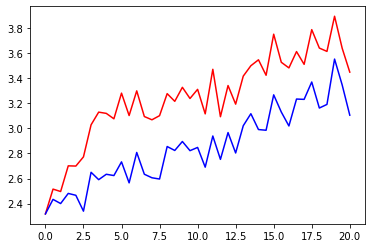

In [12]:
plt.plot(a_values, rmse_ekf_values, 'r-')
plt.plot(a_values, rmse_ghkf_values, 'b-')
plt.show()

Linear process model, nonlinear measurement model:

In [21]:
np.random.seed(2022)
Q = 10 * np.eye(1)
R = 10 * np.eye(1)
m = np.array([1]).reshape(1, 1)
P = np.array([1]).reshape(1, 1)
# z = np.array([0]).reshape(1, 1)
nsteps = 500
p = 2
dt = 0.01
def f(x, u, dt, **kwargs):
    return np.array(x + 0.1).reshape(1, 1)
def F(x, u, dt, **kwargs):
    return np.array([1]).reshape(1, 1)
a_values = np.arange(0, 20.5, 0.5)
rmse_ekf_values = []
rmse_ghkf_values = []
for a in a_values:
    def h(x, **kwargs):
    #     return 0.3*x + u
    #     return np.sin(x) + u
    #     return 0.01*x*x + u
        return x + kwargs['a']*np.sin(2*x)
    def H(x, **kwargs):
    #     return np.array([0.3]).reshape(1, 1)
    #     return np.cos(x)
    #     return 0.01*2*x
        return 1 + kwargs['a']*np.cos(2*x)*2
    kwargs = {'a': a}
    ekf = EKF.ExtendedKalmanFilter(m, P, Q, R, processModel=f, measurementModel=h, F=F, H=H, dt=dt, 
                                   measurementModelkwargs=kwargs, Hkwargs=kwargs)
    ghkf = GHKF.GH_Kalman_filter(m, P, Q, R, processModel=f, measurementModel=h, degree=p, dt=dt,
                                measurementModelkwargs=kwargs)
    x = m
    x_noisy = x + multivariate_normal.rvs([0], Q).reshape(1, 1)
    P_true = P
    xs = []
    Ps = []
    zs = []
    ms_ekf = []
    ms_ghkf = []
    Ps_ekf = []
    Ps_ghkf = []
    ts = []
    for k in range(nsteps):
        u = 0
        ekf.predict(u)
        ghkf.predict(u)
        # measurement
    #     z = h(x_noisy)
        z, Pz = trueMeanAndCov(x_noisy, P_true, f=h, u=u, f_return_dim=1, x_dim=1, 
                               dt=dt, for_measurement=True, f_kwargs=processModelkwargs)
        z_noisy = z + multivariate_normal.rvs([0], R)
        ekf.update(z_noisy)
        ghkf.update(z_noisy)
        xs.append(x_noisy)
        Ps.append(P_true)
        zs.append(z)
        ms_ekf.append(ekf.m)
        ms_ghkf.append(ghkf.m)
        Ps_ekf.append(ekf.P)
        Ps_ghkf.append(ghkf.P)
        ts.append(k * dt)
        # simulation
    #     x = f(x, u=0) + G * sqdt * np.random.randn()
        x, P_true = trueMeanAndCov(x_noisy, ghkf.P, f, u=u, f_return_dim=1, x_dim=1, dt=dt)
        x_noisy = x + multivariate_normal.rvs([0], Q).reshape(1, 1)
    estimated_positions_ekf = list(map(lambda m: m[0, 0], ms_ekf))
    estimated_positions_ghkf = list(map(lambda m: m[0, 0], ms_ghkf))
    true_positions = list(map(lambda x: x[0, 0], xs))    
    true_positions_array = np.array(true_positions)
    rmse_ekf = np.sqrt(np.sum((np.array(estimated_positions_ekf) - true_positions_array)**2 / nsteps))
    rmse_ghkf = np.sqrt(np.sum((np.array(estimated_positions_ghkf) - true_positions_array)**2 / nsteps))
    rmse_ekf_values.append(rmse_ekf)
    rmse_ghkf_values.append(rmse_ghkf)
    print(f"Finished iteration for a={a}")

Finished iteration for a=0.0
Finished iteration for a=0.5
Finished iteration for a=1.0
Finished iteration for a=1.5
Finished iteration for a=2.0
Finished iteration for a=2.5
Finished iteration for a=3.0
Finished iteration for a=3.5
Finished iteration for a=4.0
Finished iteration for a=4.5
Finished iteration for a=5.0
Finished iteration for a=5.5
Finished iteration for a=6.0
Finished iteration for a=6.5
Finished iteration for a=7.0
Finished iteration for a=7.5
Finished iteration for a=8.0
Finished iteration for a=8.5
Finished iteration for a=9.0
Finished iteration for a=9.5
Finished iteration for a=10.0
Finished iteration for a=10.5
Finished iteration for a=11.0
Finished iteration for a=11.5
Finished iteration for a=12.0
Finished iteration for a=12.5
Finished iteration for a=13.0
Finished iteration for a=13.5
Finished iteration for a=14.0
Finished iteration for a=14.5
Finished iteration for a=15.0
Finished iteration for a=15.5
Finished iteration for a=16.0
Finished iteration for a=16.5


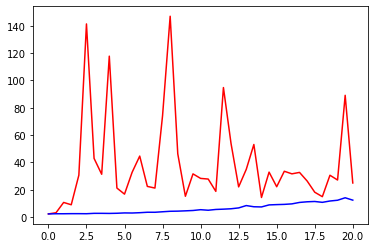

In [20]:
plt.plot(a_values, rmse_ekf_values, 'r-')
plt.plot(a_values, rmse_ghkf_values, 'b-')
plt.show()

Different nonlinear function:

In [4]:
y_dash_pk = 40
x_dash_pk = 50
x_dim = 2
z_dim = 1
kwargs = { 'y_dash_pk': y_dash_pk, 'x_dash_pk': x_dash_pk, 'x_dim': x_dim, 'z_dim': z_dim }
# def f(x, u, dt, **kwargs):
#     x1 = x[0, 0]
#     return np.array([x1 + 1]).reshape(x_dim, 1)
def f(x, u, dt, **kwargs):
    x1 = x[0, 0]
    x2 = x[1, 0]
    x1_next = x1 + dt*x2
    x2_next = x2
    x_dim = kwargs['x_dim']
    return np.array([x1_next, x2_next]).reshape(x_dim, 1)
# def F(x, u, dt, **kwargs):
#     x1 = x[0, 0]
#     return np.array([1]).reshape(x_dim, x_dim)
def F(x, u, dt, **kwargs):
    x1 = x[0, 0]
    x2 = x[1, 0]
    return np.array([[1, dt],
                     [0, 1]])

# measurement functions from BOT

def h(x, **kwargs):
    x1 = x[0, 0]
    y_dash_pk = kwargs['y_dash_pk']
    x_dash_pk = kwargs['x_dash_pk']
    z_dim = kwargs['z_dim']
    return np.array([np.arctan(y_dash_pk / (x1 - x_dash_pk))]).reshape(z_dim, 1)
def H(x, **kwargs):
    x1 = x[0, 0]
    y_dash_pk = kwargs['y_dash_pk']
    x_dash_pk = kwargs['x_dash_pk']
    x_dim = kwargs['x_dim']
    return np.array([-y_dash_pk / ((x1 - x_dash_pk)**2 * (y_dash_pk**2 / (x1 - x_dash_pk)**2 + 1)), 0]).reshape(1, x_dim)


# made-up measurement functions

# def h(x, **kwargs):
# #     return 0.3*x + u
# #     return np.sin(x) + u
# #     return 0.01*x*x + u
#     x1 = x[0, 0]
#     return np.array([x1 + 3*np.sin(2*x1)]).reshape(z_dim, 1)
# def H(x, **kwargs):
# #     return np.array([0.3]).reshape(1, 1)
# #     return np.cos(x)
# #     return 0.01*2*x
#     x1 = x[0, 0]
#     return np.array([1 + 3*np.cos(2*x1)*2, 0]).reshape(1, x_dim)

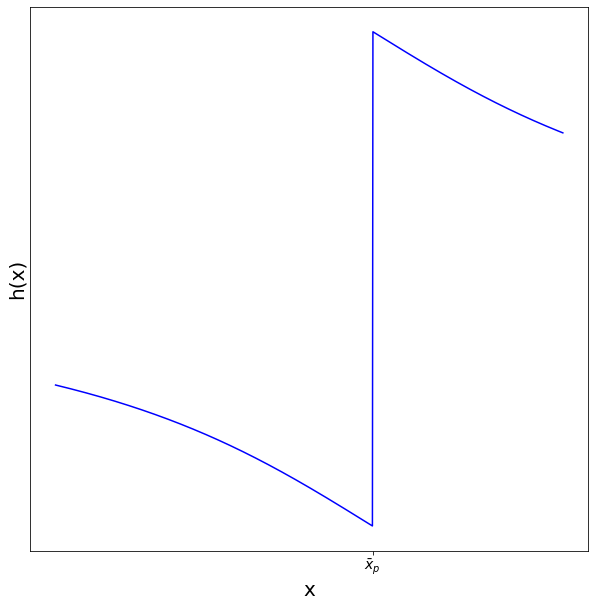

In [14]:

plt.figure(figsize=(10, 10))
ts = np.linspace(0, 80, 1000)
f_values = []
H_values = []
for t in ts:
    t = np.array([t]).reshape(1, 1)
    f_value = h(t, **kwargs)[0, 0]
    H_val = H(t, **kwargs)[0, 0]
    f_values.append(f_value)
    H_values.append(H_val)
plt.plot(ts, f_values, 'b-')
# plt.plot(ts, H_values, 'r-')
plt.xlabel('x', fontsize=20)
plt.ylabel('h(x)', fontsize=20)
plt.xticks([50], [r'$\bar{x}_p$'], fontsize=14)
plt.yticks([])
plt.savefig('BOT_h_function.jpg', bbox_inches='tight')
plt.show()

In [27]:
np.random.seed(2022)
Q = 0.1 * np.eye(x_dim)
R = 0.1 * np.eye(z_dim)
m = np.array([45, 30]).reshape(x_dim, 1)
# P = np.array([1]).reshape(1, 1)
P = np.eye(x_dim)
nsteps = 50
p = 3
dt = 0.01

In [28]:
ekf = EKF.ExtendedKalmanFilter(m, P, Q, R, processModel=f, measurementModel=h, F=F, H=H, dt=dt, kwargs=kwargs)
ghkf = GHKF.GH_Kalman_filter(m, P, Q, R, processModel=f, measurementModel=h, degree=p, dt=dt, kwargs=kwargs)
x = m
x_noisy = x + multivariate_normal.rvs(np.zeros(x_dim), Q).reshape(x_dim, 1)
P_true = P
xs = []
Ps = []
zs = []
ms_ekf = []
ms_ghkf = []
Ps_ekf = []
Ps_ghkf = []
ts = []
for k in range(nsteps):
    u = 0
    ekf.predict(u)
    ghkf.predict(u)
    # measurement
#     z = h(x_noisy)
    z, Pz = trueMeanAndCov(x_noisy, P_true, f=h, u=u, f_return_dim=z_dim, x_dim=x_dim, 
                           dt=dt, for_measurement=True, f_kwargs=kwargs)
    z_noisy = z + multivariate_normal.rvs(np.zeros(z_dim), R)
    ekf.update(z_noisy)
    ghkf.update(z_noisy)
    xs.append(x)
    Ps.append(P_true)
    zs.append(z)
    ms_ekf.append(ekf.m)
    ms_ghkf.append(ghkf.m)
    Ps_ekf.append(ekf.P)
    Ps_ghkf.append(ghkf.P)
    ts.append(k * dt)
    # simulation
#     x = f(x, u=0) + G * sqdt * np.random.randn()
    x, P_true = trueMeanAndCov(x_noisy, ghkf.P, f, u=u, f_return_dim=x_dim, x_dim=x_dim, dt=dt, f_kwargs=kwargs)
    x_noisy = x + multivariate_normal.rvs(np.zeros(x_dim), Q).reshape(x_dim, 1)
estimated_positions_ekf = list(map(lambda m: m[0, 0], ms_ekf))
estimated_positions_ghkf = list(map(lambda m: m[0, 0], ms_ghkf))
true_positions = list(map(lambda x: x[0, 0], xs))    
true_positions_array = np.array(true_positions)
rmse_ekf = np.sqrt(np.sum((np.array(estimated_positions_ekf) - true_positions_array)**2 / nsteps))
rmse_ghkf = np.sqrt(np.sum((np.array(estimated_positions_ghkf) - true_positions_array)**2 / nsteps))

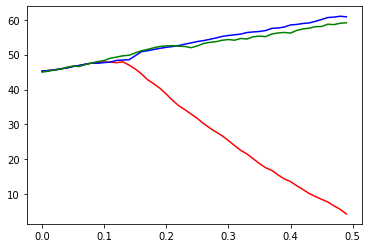

In [29]:
plt.plot(ts, estimated_positions_ekf, 'r-')
plt.plot(ts, estimated_positions_ghkf, 'b-')
plt.plot(ts, true_positions, 'g-')
plt.show()

In [22]:
rmse_ekf

0.9983898063941414

In [23]:
rmse_ghkf

0.9943247766203686

#### 2 dim test

In [54]:
np.random.seed(2022)
Q = 10 * np.eye(2)
R = 10 * np.eye(1)
m = np.array([1, 1]).reshape(2, 1)
P = np.eye(2)
# z = np.array([0]).reshape(1, 1)
nsteps = 100
p = 3
dt = 0.01
def f(x, u, dt, **kwargs):
    x1 = x[0, 0]
    x2 = x[1, 0]
    return np.array([x1 + dt*x2, x2]).reshape(2, 1)
def F(x, u, dt, **kwargs):
    return np.array([[1, dt],
                     [0, 1]])
a_values = np.arange(0, 20.5, 0.5)
rmse_ekf_values = []
rmse_ghkf_values = []
for a in a_values:
    def h(x, **kwargs):
    #     return 0.3*x + u
    #     return np.sin(x) + u
    #     return 0.01*x*x + u
        x1 = x[0, 0]
        return x1 + kwargs['a']*np.sin(2*x1)
    def H(x, **kwargs):
    #     return np.array([0.3]).reshape(1, 1)
    #     return np.cos(x)
    #     return 0.01*2*x
        x1 = x[0, 0]
        return np.array([1 + kwargs['a']*np.cos(2*x1)*2, 0]).reshape(1, 2)
    kwargs = {'a': a}
    ekf = EKF.ExtendedKalmanFilter(m, P, Q, R, processModel=f, measurementModel=h, F=F, H=H, dt=dt, kwargs=kwargs)
    ghkf = GHKF.GH_Kalman_filter(m, P, Q, R, processModel=f, measurementModel=h, degree=p, dt=dt, kwargs=kwargs)
    x = m
    x_noisy = x + multivariate_normal.rvs([0, 0], Q).reshape(2, 1)
    P_true = P
    xs = []
    Ps = []
    zs = []
    ms_ekf = []
    ms_ghkf = []
    Ps_ekf = []
    Ps_ghkf = []
    ts = []
    for k in range(nsteps):
        u = 0
        ekf.predict(u)
        ghkf.predict(u)
        # measurement
    #     z = h(x_noisy)
        z, Pz = trueMeanAndCov(x_noisy, P_true, f=h, u=u, f_return_dim=1, x_dim=2, 
                               dt=dt, for_measurement=True, f_kwargs=kwargs)
        z_noisy = z + multivariate_normal.rvs([0], R).reshape(1, 1)
        ekf.update(z_noisy)
        ghkf.update(z_noisy)
        xs.append(x_noisy)
        Ps.append(P_true)
        zs.append(z)
        ms_ekf.append(ekf.m)
        ms_ghkf.append(ghkf.m)
        Ps_ekf.append(ekf.P)
        Ps_ghkf.append(ghkf.P)
        ts.append(k * dt)
        # simulation
    #     x = f(x, u=0) + G * sqdt * np.random.randn()
        x, P_true = trueMeanAndCov(x_noisy, ghkf.P, f, u=u, f_return_dim=2, x_dim=2, dt=dt)
        x_noisy = x + multivariate_normal.rvs([0, 0], Q).reshape(2, 1)
    estimated_positions_ekf = list(map(lambda m: m[0, 0], ms_ekf))
    estimated_positions_ghkf = list(map(lambda m: m[0, 0], ms_ghkf))
    true_positions = list(map(lambda x: x[0, 0], xs))    
    true_positions_array = np.array(true_positions)
    rmse_ekf = np.sqrt(np.sum((np.array(estimated_positions_ekf) - true_positions_array)**2 / nsteps))
    rmse_ghkf = np.sqrt(np.sum((np.array(estimated_positions_ghkf) - true_positions_array)**2 / nsteps))
    rmse_ekf_values.append(rmse_ekf)
    rmse_ghkf_values.append(rmse_ghkf)
    print(f"Finished iteration for a={a}")

Finished iteration for a=0.0
Finished iteration for a=0.5
Finished iteration for a=1.0
Finished iteration for a=1.5
Finished iteration for a=2.0
Finished iteration for a=2.5
Finished iteration for a=3.0
Finished iteration for a=3.5
Finished iteration for a=4.0
Finished iteration for a=4.5
Finished iteration for a=5.0
Finished iteration for a=5.5
Finished iteration for a=6.0
Finished iteration for a=6.5
Finished iteration for a=7.0
Finished iteration for a=7.5
Finished iteration for a=8.0
Finished iteration for a=8.5
Finished iteration for a=9.0
Finished iteration for a=9.5
Finished iteration for a=10.0
Finished iteration for a=10.5
Finished iteration for a=11.0
Finished iteration for a=11.5
Finished iteration for a=12.0
Finished iteration for a=12.5
Finished iteration for a=13.0
Finished iteration for a=13.5
Finished iteration for a=14.0
Finished iteration for a=14.5
Finished iteration for a=15.0
Finished iteration for a=15.5
Finished iteration for a=16.0
Finished iteration for a=16.5


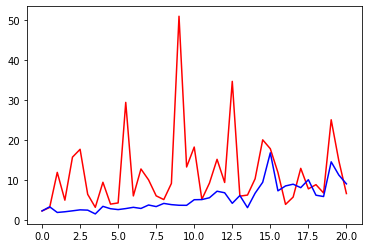

In [55]:
plt.plot(a_values, rmse_ekf_values, 'r-')
plt.plot(a_values, rmse_ghkf_values, 'b-')
plt.show()

In [43]:
np.random.seed(2022)
Q = 10 * np.eye(2)
R = 10 * np.eye(1)
m = np.array([1, 1]).reshape(2, 1)
P = np.eye(2)
nsteps = 100
dt = 0.01
def f(x, u, dt, **kwargs):
    x1 = x[0, 0]
    x2 = x[1, 0]
    return np.array([x1 + dt*x2, x2]).reshape(2, 1)
def F(x, u, dt, **kwargs):
    return np.array([[1, dt],
                     [0, 1]])
def h(x, **kwargs):
#     return 0.3*x + u
#     return np.sin(x) + u
#     return 0.01*x*x + u
    x1 = x[0, 0]
    return x1 + kwargs['a']*np.sin(2*x1)
def H(x, **kwargs):
#     return np.array([0.3]).reshape(1, 1)
#     return np.cos(x)
#     return 0.01*2*x
    x1 = x[0, 0]
    return np.array([1 + kwargs['a']*np.cos(2*x1)*2, 0]).reshape(1, 2)
kwargs = {'a': a}
ekf = EKF.ExtendedKalmanFilter(m, P, Q, R, processModel=f, measurementModel=h, F=F, H=H, dt=dt, kwargs=kwargs)
x = m
x_noisy = x + multivariate_normal.rvs([0, 0], Q).reshape(2, 1)
P_true = P
xs = []
Ps = []
zs = []
ms_ekf = []
ts = []
t_start = perf_counter()
for k in range(nsteps):
    u = 0
    ekf.predict(u)
    # measurement
#     z = h(x_noisy)
    z, Pz = trueMeanAndCov(x_noisy, P_true, f=h, u=u, f_return_dim=1, x_dim=2, 
                           dt=dt, for_measurement=True, f_kwargs=kwargs)
    z_noisy = z + multivariate_normal.rvs([0], R).reshape(1, 1)
    ekf.update(z_noisy)
    xs.append(x_noisy)
    ms_ekf.append(ekf.m)
    ts.append(k * dt)
    # simulation
#     x = f(x, u=0) + G * sqdt * np.random.randn()
    x, P_true = trueMeanAndCov(x_noisy, ekf.P, f, u=u, f_return_dim=2, x_dim=2, dt=dt)
    x_noisy = x + multivariate_normal.rvs([0, 0], Q).reshape(2, 1)
t_stop = perf_counter()
time = t_stop - t_start
time

0.3877286999995704

In [48]:
np.random.seed(2022)
Q = 10 * np.eye(2)
R = 10 * np.eye(1)
m = np.array([1, 1]).reshape(2, 1)
P = np.eye(2)
nsteps = 100
dt = 0.01
def f(x, u, dt, **kwargs):
    x1 = x[0, 0]
    x2 = x[1, 0]
    return np.array([x1 + dt*x2, x2]).reshape(2, 1)
def F(x, u, dt, **kwargs):
    return np.array([[1, dt],
                     [0, 1]])
def h(x, **kwargs):
#     return 0.3*x + u
#     return np.sin(x) + u
#     return 0.01*x*x + u
    x1 = x[0, 0]
    return x1 + kwargs['a']*np.sin(2*x1)
def H(x, **kwargs):
#     return np.array([0.3]).reshape(1, 1)
#     return np.cos(x)
#     return 0.01*2*x
    x1 = x[0, 0]
    return np.array([1 + kwargs['a']*np.cos(2*x1)*2, 0]).reshape(1, 2)
kwargs = {'a': a}
ghkf = GHKF.GH_Kalman_filter(m, P, Q, R, processModel=f, measurementModel=h, degree=5, dt=dt, kwargs=kwargs)
x = m
x_noisy = x + multivariate_normal.rvs([0, 0], Q).reshape(2, 1)
P_true = P
xs = []
Ps = []
zs = []
ms_ghkf = []
ts = []
t_start = perf_counter()
for k in range(nsteps):
    u = 0
    ghkf.predict(u)
    # measurement
#     z = h(x_noisy)
    z, Pz = trueMeanAndCov(x_noisy, P_true, f=h, u=u, f_return_dim=1, x_dim=2, 
                           dt=dt, for_measurement=True, f_kwargs=kwargs)
    z_noisy = z + multivariate_normal.rvs([0], R).reshape(1, 1)
    ghkf.update(z_noisy)
    xs.append(x_noisy)
    ms_ghkf.append(ghkf.m)
    ts.append(k * dt)
    # simulation
#     x = f(x, u=0) + G * sqdt * np.random.randn()
    x, P_true = trueMeanAndCov(x_noisy, ghkf.P, f, u=u, f_return_dim=2, x_dim=2, dt=dt)
    x_noisy = x + multivariate_normal.rvs([0, 0], Q).reshape(2, 1)
t_stop = perf_counter()
time = t_stop - t_start
time

0.5052402999972401

#### Polar to carthesian coords

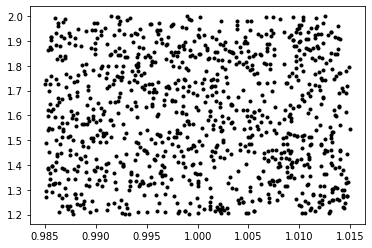

In [12]:
np.random.seed(2022)
nsamples = 1000
rs = []
thetas = []
for i in range(nsamples):
    r = np.random.uniform(low=0.985, high=1.015, size=1)
    theta = np.random.uniform(low=1.2, high=2, size=1)
    rs.append(r)
    thetas.append(theta)
rs = np.array(rs)
thetas = np.array(thetas)
plt.plot(rs, thetas, 'k.')
plt.show()

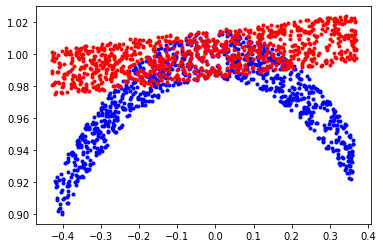

In [14]:
xs = rs * np.cos(thetas)
ys = rs * np.sin(thetas)
rs_mean = np.mean(rs)
thetas_mean = np.mean(thetas)
xs_lin = rs_mean*np.cos(thetas_mean) + np.cos(thetas_mean)*(rs - rs_mean) - rs_mean*np.sin(thetas_mean)*(thetas-thetas_mean)
ys_lin = rs_mean*np.sin(thetas_mean) + np.sin(thetas_mean)*(rs - rs_mean) + rs_mean*np.cos(thetas_mean)*(thetas-thetas_mean)
plt.plot(xs, ys, 'b.')
plt.plot(xs_lin, ys_lin, 'r.')
plt.show()

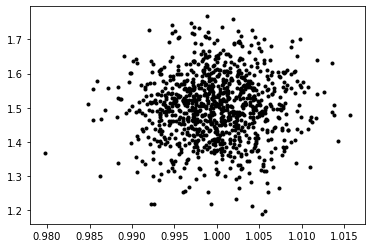

In [18]:
rs = []
thetas = []
for i in range(nsamples):
    r = np.random.normal(loc=1, scale=0.005, size=1)
    theta = np.random.normal(loc=1.5, scale=0.1, size=1)
    rs.append(r)
    thetas.append(theta)
rs = np.array(rs)
thetas = np.array(thetas)
plt.plot(rs, thetas, 'k.')
plt.show()

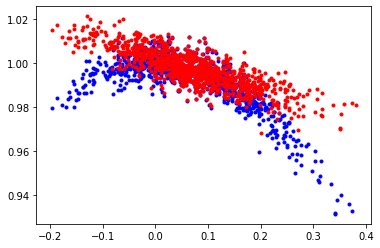

In [19]:
xs = rs * np.cos(thetas)
ys = rs * np.sin(thetas)
rs_mean = np.mean(rs)
thetas_mean = np.mean(thetas)
xs_lin = rs_mean*np.cos(thetas_mean) + np.cos(thetas_mean)*(rs - rs_mean) - rs_mean*np.sin(thetas_mean)*(thetas-thetas_mean)
ys_lin = rs_mean*np.sin(thetas_mean) + np.sin(thetas_mean)*(rs - rs_mean) + rs_mean*np.cos(thetas_mean)*(thetas-thetas_mean)
plt.plot(xs, ys, 'b.')
plt.plot(xs_lin, ys_lin, 'r.')
plt.show()

In [22]:
r, t = sympy.symbols('r, t')
H = sympy.Matrix([r*sympy.cos(t), r*sympy.sin(t)])
state = sympy.Matrix([r, t])
J = H.jacobian(state)
display(state)
display(H)
display(J)

Matrix([
[r],
[t]])

Matrix([
[r*cos(t)],
[r*sin(t)]])

Matrix([
[cos(t), -r*sin(t)],
[sin(t),  r*cos(t)]])

In [24]:
x_dim = 2
z_dim = 2
kwargs = { 'x_dim': x_dim, 'z_dim': z_dim }
def f(x, u, dt, **kwargs):
    x1 = x[0, 0]
    x2 = x[1, 0]
    x1_next = x1 + 1
    x2_next = x2 + 0.1
    x_dim = kwargs['x_dim']
    return np.array([x1_next, x2_next]).reshape(x_dim, 1)
def F(x, u, dt, **kwargs):
    x1 = x[0, 0]
    x2 = x[1, 0]
    return np.array([[1, 0],
                     [0, 1]])
def h(x, **kwargs):
    r = x[0, 0]
    theta = x[1, 0]
    z_dim = kwargs['z_dim']
    return np.array([r*np.cos(theta), r*np.sin(theta)]).reshape(z_dim, 1)
def H(x, **kwargs):
#     return np.array([0.3]).reshape(1, 1)
#     return np.cos(x)
#     return 0.01*2*x
    r = x[0, 0]
    theta = x[1, 0]
    return np.array([[np.cos(theta), -r*np.sin(theta)],
                     [np.sin(theta), r*np.cos(theta)]])

In [25]:
np.random.seed(2022)
Q = 0.1 * np.eye(x_dim)
R = 0.1 * np.eye(z_dim)
m = np.array([1, 1.5]).reshape(x_dim, 1)
# P = np.array([1]).reshape(1, 1)
P = np.eye(x_dim)
nsteps = 50
p = 3
dt = 0.01

In [30]:
ekf = EKF.ExtendedKalmanFilter(m, P, Q, R, processModel=f, measurementModel=h, F=F, H=H, dt=dt, kwargs=kwargs)
ghkf = GHKF.GH_Kalman_filter(m, P, Q, R, processModel=f, measurementModel=h, degree=p, dt=dt, kwargs=kwargs)
x = m
x_noisy = x + multivariate_normal.rvs(np.zeros(x_dim), Q).reshape(x_dim, 1)
P_true = P
xs = []
Ps = []
zs = []
ms_ekf = []
ms_ghkf = []
Ps_ekf = []
Ps_ghkf = []
ts = []
for k in range(nsteps):
    u = 0
    ekf.predict(u)
    ghkf.predict(u)
    # measurement
#     z = h(x_noisy)
    z, Pz = trueMeanAndCov(x_noisy, P_true, f=h, u=u, f_return_dim=z_dim, x_dim=x_dim, 
                           dt=dt, for_measurement=True, f_kwargs=kwargs)
    z_noisy = z + multivariate_normal.rvs(np.zeros(z_dim), R)
    ekf.update(z_noisy)
    ghkf.update(z_noisy)
    xs.append(x)
    Ps.append(P_true)
    zs.append(z)
    ms_ekf.append(ekf.m)
    ms_ghkf.append(ghkf.m)
    Ps_ekf.append(ekf.P)
    Ps_ghkf.append(ghkf.P)
    ts.append(k * dt)
    # simulation
#     x = f(x, u=0) + G * sqdt * np.random.randn()
    x, P_true = trueMeanAndCov(x_noisy, ghkf.P, f, u=u, f_return_dim=x_dim, x_dim=x_dim, dt=dt, f_kwargs=kwargs)
    x_noisy = x + multivariate_normal.rvs(np.zeros(x_dim), Q).reshape(x_dim, 1)
estimated_r_ekf = list(map(lambda m: m[0, 0], ms_ekf))
estimated_r_ghkf = list(map(lambda m: m[0, 0], ms_ghkf))
estimated_theta_ekf = list(map(lambda m: m[1, 0], ms_ekf))
estimated_theta_ghkf = list(map(lambda m: m[1, 0], ms_ghkf))
true_positions = list(map(lambda x: x[0, 0], xs))
true_theta = list(map(lambda x: x[1, 0], xs))
true_positions_array = np.array(true_positions)
rmse_ekf = np.sqrt(np.sum((np.array(estimated_positions_ekf) - true_positions_array)**2 / nsteps))
rmse_ghkf = np.sqrt(np.sum((np.array(estimated_positions_ghkf) - true_positions_array)**2 / nsteps))

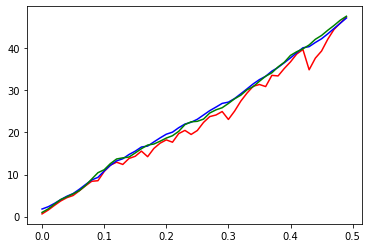

In [31]:
plt.plot(ts, estimated_r_ekf, 'r-')
plt.plot(ts, estimated_r_ghkf, 'b-')
plt.plot(ts, true_positions, 'g-')
plt.show()

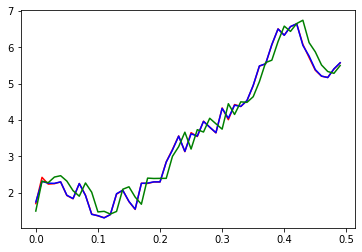

In [32]:
plt.plot(ts, estimated_theta_ekf, 'r-')
plt.plot(ts, estimated_theta_ghkf, 'b-')
plt.plot(ts, true_theta, 'g-')
plt.show()

#### Liu function 1:

In [4]:
x1, x2 = sympy.symbols('x_1, x_2')
F = sympy.Matrix([[0.8*x1 + x1*x2 + 0.1, 1.5*x2 - x1*x2 + 0.1]])
state = sympy.Matrix([x1, x2])
J = F.jacobian(state)
display(state)
display(F)
display(J)

Matrix([
[x_1],
[x_2]])

Matrix([[x_1*x_2 + 0.8*x_1 + 0.1, -x_1*x_2 + 1.5*x_2 + 0.1]])

Matrix([
[x_2 + 0.8,       x_1],
[     -x_2, 1.5 - x_1]])

In [5]:
x_dim = 2
z_dim = 2
kwargs = { 'x_dim': x_dim, 'z_dim': z_dim }
def f(x, u, dt, **kwargs):
    x1 = x[0, 0]
    x2 = x[1, 0]
    x1_next = 0.8*x1 + x1*x2 + 0.1
    x2_next = 1.5*x2 - x1*x2 + 0.1
    x_dim = kwargs['x_dim']
    return np.array([x1_next, x2_next]).reshape(x_dim, 1)
def F(x, u, dt, **kwargs):
    x1 = x[0, 0]
    x2 = x[1, 0]
    return np.array([[x2+0.8, x1],
                     [-x2, 1.5-x1]])
def h(x, **kwargs):
    x1 = x[0, 0]
    x2 = x[1, 0]
    z_dim = kwargs['z_dim']
    return np.array([x1, x2]).reshape(z_dim, 1)
def H(x, **kwargs):
    return np.array([[1, 0],
                     [0, 1]])

In [6]:
Q = np.diag([0.1, 0.2])
R = np.diag([0.1, 0.2])
m = np.array([1, 1]).reshape(x_dim, 1)
P = np.eye(x_dim)
nsteps = 50
p = 3
dt = 1

In [7]:
np.random.seed(2022)
ekf = EKF.ExtendedKalmanFilter(m, P, Q, R, processModel=f, measurementModel=h, F=F, H=H, dt=dt, kwargs=kwargs)
ghkf = GHKF.GH_Kalman_filter(m, P, Q, R, processModel=f, measurementModel=h, degree=p, dt=dt, kwargs=kwargs)
x = m
x_noisy = x + 0.01*multivariate_normal.rvs(np.zeros(x_dim), Q).reshape(x_dim, 1)
P_true = P
xs = []
Ps = []
zs = []
ms_ekf = []
ms_ghkf = []
Ps_ekf = []
Ps_ghkf = []
ts = []
for k in range(nsteps):
    u = 0
    ekf.predict(u)
    ghkf.predict(u)
    # measurement
    z = h(x_noisy, **kwargs)
#     z, Pz = trueMeanAndCov(x_noisy, P_true, f=h, u=u, f_return_dim=z_dim, x_dim=x_dim, 
#                            dt=dt, for_measurement=True, f_kwargs=kwargs)
    z_noisy = z + 0.04*multivariate_normal.rvs(np.zeros(z_dim), R).reshape(z_dim, 1)
    ekf.update(z_noisy)
    ghkf.update(z_noisy)
    xs.append(x_noisy)
    Ps.append(P_true)
    zs.append(z_noisy)
    ms_ekf.append(ekf.m)
    ms_ghkf.append(ghkf.m)
    Ps_ekf.append(ekf.P)
    Ps_ghkf.append(ghkf.P)
    ts.append(k * dt)
    # simulation
#     x = f(x_noisy, u=0, dt=dt, **kwargs)
    x, P_true = trueMeanAndCov(x_noisy, ghkf.P, f, u=u, f_return_dim=x_dim, x_dim=x_dim, dt=dt, f_kwargs=kwargs)
    x_noisy = x + 0.01*multivariate_normal.rvs(np.zeros(x_dim), Q).reshape(x_dim, 1)
estimated_x1_ekf = np.array(list(map(lambda m: m[0, 0], ms_ekf)))
estimated_x1_ghkf = np.array(list(map(lambda m: m[0, 0], ms_ghkf)))
estimated_x2_ekf = np.array(list(map(lambda m: m[1, 0], ms_ekf)))
estimated_x2_ghkf = np.array(list(map(lambda m: m[1, 0], ms_ghkf)))
true_x1 = np.array(list(map(lambda x: x[0, 0], xs)))
zs_x1 = np.array(list(map(lambda z: z[0, 0], zs)))
true_x2 = np.array(list(map(lambda x: x[1, 0], xs)))
rmse_ekf_x1 = np.sqrt(np.sum((estimated_x1_ekf - true_x1)**2 / nsteps))
rmse_ghkf_x1 = np.sqrt(np.sum((estimated_x1_ghkf - true_x1)**2 / nsteps))
rmse_ekf_x2 = np.sqrt(np.sum((estimated_x2_ekf - true_x2)**2 / nsteps))
rmse_ghkf_x2 = np.sqrt(np.sum((estimated_x2_ghkf - true_x2)**2 / nsteps))

In [8]:
rmse_ekf_x1

0.012441362170840967

In [9]:
rmse_ghkf_x1

0.01246588547613959

In [10]:
rmse_ekf_x2

0.010425813330996075

In [11]:
rmse_ghkf_x2

0.009618775370043011

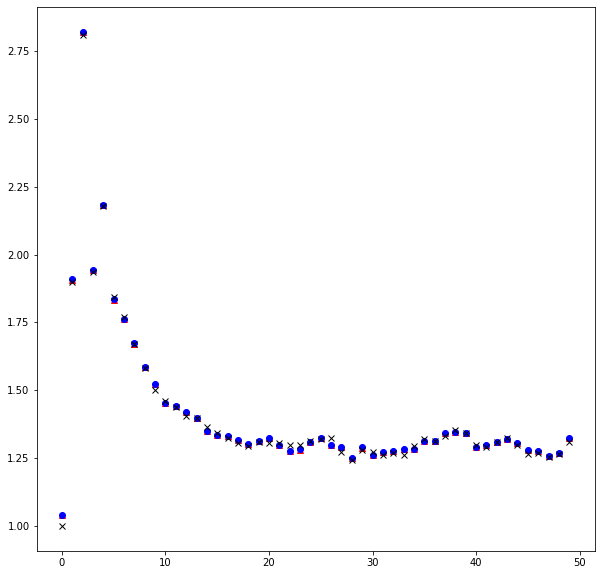

In [21]:
plt.figure(figsize=(10, 10))
plt.plot(ts, estimated_x1_ekf, 'r^')
plt.plot(ts, estimated_x1_ghkf, 'bo')
plt.plot(ts, true_x1, 'kx')
plt.show()

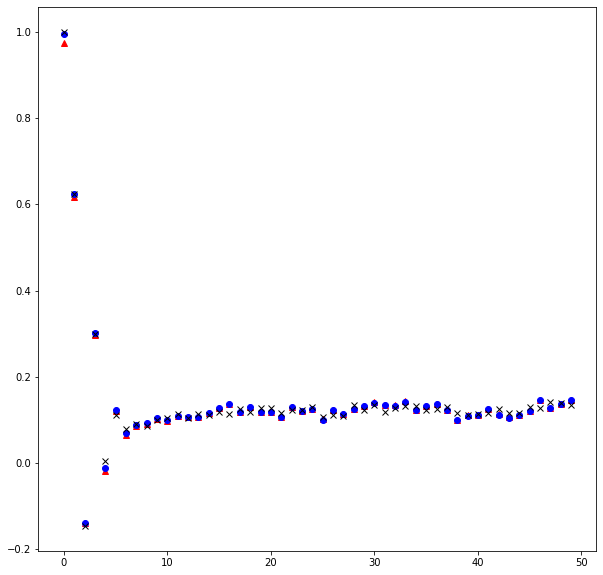

In [22]:
plt.figure(figsize=(10, 10))
plt.plot(ts, estimated_x2_ekf, 'r^')
plt.plot(ts, estimated_x2_ghkf, 'bo')
plt.plot(ts, true_x2, 'kx')
plt.show()

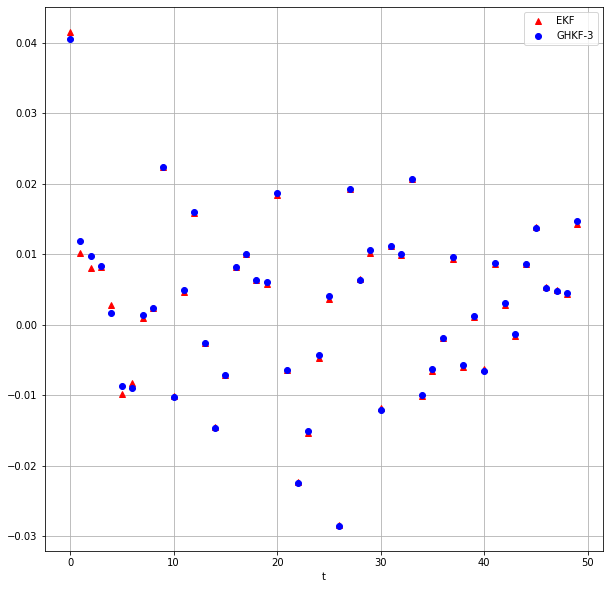

In [14]:
plt.figure(figsize=(10, 10))
plt.plot(ts, estimated_x1_ekf - true_x1, 'r^')
plt.plot(ts, estimated_x1_ghkf - true_x1, 'bo')
plt.xlabel('t')
plt.legend(['EKF', 'GHKF-3'])
plt.grid()
plt.show()

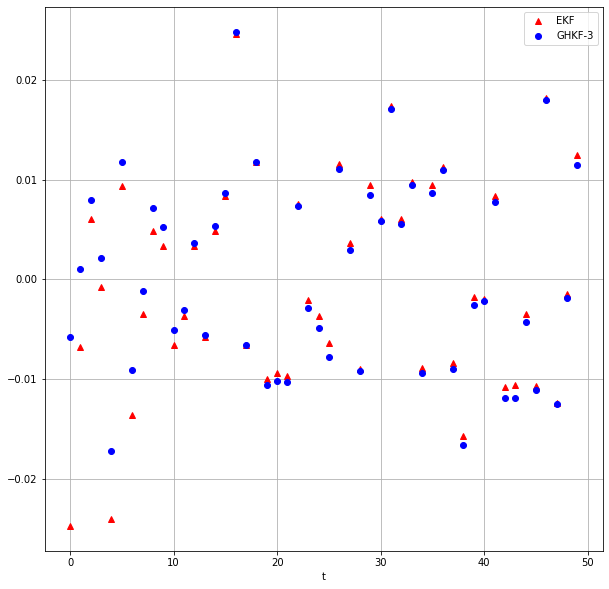

In [23]:
plt.figure(figsize=(10, 10))
plt.plot(ts, estimated_x2_ekf - true_x2, 'r^')
plt.plot(ts, estimated_x2_ghkf - true_x2, 'bo')
plt.xlabel('t')
plt.legend(['EKF', 'GHKF-3'])
plt.grid()
plt.show()

#### Liu function 2:

In [55]:
x1, x2, a, b = sympy.symbols('x_1, x_2, a, b')
F = sympy.Matrix([[0.85*x1 + 0.5*x2*sympy.sin(x1) + a, 
                   1.15*b - 0.5*x1*sympy.sin(x2)]])
state = sympy.Matrix([x1, x2])
J = F.jacobian(state)
display(state)
display(F)
display(J)

Matrix([
[x_1],
[x_2]])

Matrix([[a + 0.85*x_1 + 0.5*x_2*sin(x_1), 1.15*b - 0.5*x_1*sin(x_2)]])

Matrix([
[0.5*x_2*cos(x_1) + 0.85,      0.5*sin(x_1)],
[          -0.5*sin(x_2), -0.5*x_1*cos(x_2)]])

In [167]:
x_dim = 2
z_dim = 1
kwargs = { 'x_dim': x_dim, 'z_dim': z_dim, 'k': 0, 'b': 0 }
def f(x, u, dt, **kwargs):
    x1 = x[0, 0]
    x2 = x[1, 0]
    k = kwargs['k']
    b = kwargs['b']
    if k > 20:
        a = 0.003
    else:
        a = 0
    x1_next = 0.85*x1 + 0.5*x2*np.sin(x1) + a
    x2_next = 1.15*b - 0.5*x1*np.sin(x2)
    x_dim = kwargs['x_dim']
    return np.array([x1_next, x2_next]).reshape(x_dim, 1)
def F(x, u, dt, **kwargs):
    x1 = x[0, 0]
    x2 = x[1, 0]
    return np.array([[0.5*x2*np.cos(x1) + 0.85, 0.5*np.sin(x1)],
                     [-0.5*np.sin(x2), -0.5*x1*np.cos(x2)]])
def h(x, **kwargs):
    x2 = x[1, 0]
    z_dim = kwargs['z_dim']
    return np.array([x2]).reshape(z_dim, 1)
def H(x, **kwargs):
    return np.array([0, 1]).reshape(z_dim, x_dim)

In [168]:
Q = np.diag([0.002, 0.002])
R = np.diag([0.004])
m = np.array([0, 0]).reshape(x_dim, 1)
P = np.eye(x_dim)
nsteps = 50
p = 3
dt = 1

In [169]:
np.random.seed(2022)
ekf = EKF.ExtendedKalmanFilter(m, P, Q, R, processModel=f, measurementModel=h, F=F, H=H, dt=dt, kwargs=kwargs)
ghkf = GHKF.GH_Kalman_filter(m, P, Q, R, processModel=f, measurementModel=h, degree=p, dt=dt, kwargs=kwargs)
x = m
z_noisy = np.array([0]).reshape(1, 1)
x_noisy = x + multivariate_normal.rvs(np.zeros(x_dim), Q).reshape(x_dim, 1)
P_true = P
xs = []
Ps = []
zs = []
ms_ekf = []
ms_ghkf = []
Ps_ekf = []
Ps_ghkf = []
ts = []
for k in range(nsteps):
    u = 0
    
    kwargs['k'] = k
    ekf.kwargs = kwargs
    ghkf.kwargs = kwargs
    ekf.predict(u)
    ghkf.predict(u)
    # measurement
    z = h(x_noisy, **kwargs)
#     z, Pz = trueMeanAndCov(x_noisy, P_true, f=h, u=u, f_return_dim=z_dim, x_dim=x_dim, 
#                            dt=dt, for_measurement=True, f_kwargs=kwargs)
    z_noisy = z + multivariate_normal.rvs(np.zeros(z_dim), R).reshape(z_dim, 1)
    kwargs['b'] = z_noisy[0, 0]
    ekf.kwargs = kwargs
    ghkf.kwargs = kwargs
    ekf.update(z_noisy)
    ghkf.update(z_noisy)
    xs.append(x_noisy)
    Ps.append(P_true)
    zs.append(z_noisy)
    ms_ekf.append(ekf.m)
    ms_ghkf.append(ghkf.m)
    Ps_ekf.append(ekf.P)
    Ps_ghkf.append(ghkf.P)
    ts.append(k * dt)
    # simulation
#     x = f(x_noisy, u=0, dt=dt, **kwargs)
    x, P_true = trueMeanAndCov(x_noisy, ghkf.P, f, u=u, f_return_dim=x_dim, x_dim=x_dim, dt=dt, f_kwargs=kwargs)
    x_noisy = x + multivariate_normal.rvs(np.zeros(x_dim), Q).reshape(x_dim, 1)
estimated_x1_ekf = list(map(lambda m: m[0, 0], ms_ekf))
estimated_x1_ghkf = list(map(lambda m: m[0, 0], ms_ghkf))
estimated_x2_ekf = list(map(lambda m: m[1, 0], ms_ekf))
estimated_x2_ghkf = list(map(lambda m: m[1, 0], ms_ghkf))
true_x1 = list(map(lambda x: x[0, 0], xs))
zs_x2 = list(map(lambda z: z[0, 0], zs))
true_x2 = list(map(lambda x: x[1, 0], xs))

true_x1_array = np.array(true_x1)
rmse_ekf_x1 = np.sqrt(np.sum((np.array(estimated_x1_ekf) - true_x1_array)**2 / nsteps))
rmse_ghkf_x1 = np.sqrt(np.sum((np.array(estimated_x1_ghkf) - true_x1_array)**2 / nsteps))

true_x2_array = np.array(true_x2)
rmse_ekf_x2 = np.sqrt(np.sum((np.array(estimated_x2_ekf) - true_x2_array)**2 / nsteps))
rmse_ghkf_x2 = np.sqrt(np.sum((np.array(estimated_x2_ghkf) - true_x2_array)**2 / nsteps))

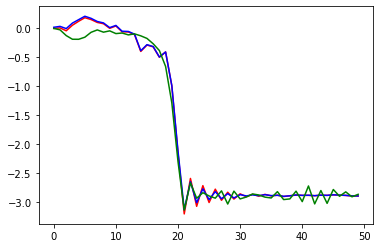

In [170]:
plt.plot(ts, estimated_x1_ekf, 'r-')
plt.plot(ts, estimated_x1_ghkf, 'b-')
plt.plot(ts, true_x1, 'g-')
plt.show()

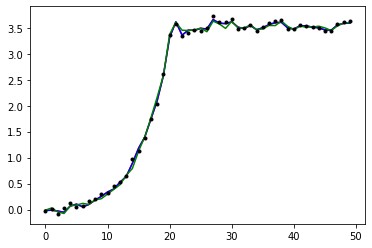

In [171]:
plt.plot(ts, estimated_x2_ekf, 'r-')
plt.plot(ts, estimated_x2_ghkf, 'b-')
plt.plot(ts, true_x2, 'g-')
plt.plot(ts, zs_x2, 'k.')
plt.show()

In [172]:
rmse_ekf_x1

0.13817814337312992

In [173]:
rmse_ghkf_x1

0.13918050302155197

In [174]:
rmse_ekf_x2

0.036940838522218154

In [175]:
rmse_ghkf_x2

0.03641264545600045

#### Kalman and bayesian filters in python function:

In [29]:
x1, x2 = sympy.symbols('x_1, x_2')
F = sympy.Matrix([x1 + x2, 0.1 * x1**2 + sympy.sin(x2)*x2**2])
state = sympy.Matrix([x1, x2])
J = F.jacobian(state)
display(state)
display(F)
display(J)

Matrix([
[x_1],
[x_2]])

Matrix([
[                   x_1 + x_2],
[0.1*x_1**2 + x_2**2*sin(x_2)]])

Matrix([
[      1,                                1],
[0.2*x_1, x_2**2*cos(x_2) + 2*x_2*sin(x_2)]])

In [30]:
x_dim = 2
z_dim = 1
kwargs = { 'x_dim': x_dim, 'z_dim': z_dim}
def f(x, u, dt, **kwargs):
    x1 = x[0, 0]
    x2 = x[1, 0]
    x1_next = x1 + x2
    x2_next = 0.1 * x1**2 + np.sin(x2)*x2**2
    x_dim = kwargs['x_dim']
    return np.array([x1_next, x2_next]).reshape(x_dim, 1)
def F(x, u, dt, **kwargs):
    x1 = x[0, 0]
    x2 = x[1, 0]
    return np.array([[1, 1],
                     [0.2*x1, x2**2 * np.cos(x2) + 2*x2*np.sin(x2)]])
def h(x, **kwargs):
    x1 = x[0, 0]
    z_dim = kwargs['z_dim']
    return np.array([x1]).reshape(z_dim, 1)
def H(x, **kwargs):
    return np.array([1, 0]).reshape(z_dim, x_dim)

In [31]:
Q = np.diag([1, 1])
R = np.diag([1])
m = np.array([0, 0]).reshape(x_dim, 1)
P = np.eye(x_dim)
nsteps = 5
p = 3
dt = 1

In [32]:
np.random.seed(2022)
ekf = EKF.ExtendedKalmanFilter(m, P, Q, R, processModel=f, measurementModel=h, F=F, H=H, dt=dt, kwargs=kwargs)
ghkf = GHKF.GH_Kalman_filter(m, P, Q, R, processModel=f, measurementModel=h, degree=p, dt=dt, kwargs=kwargs)
x = m
z_noisy = np.array([0]).reshape(1, 1)
x_noisy = x + multivariate_normal.rvs(np.zeros(x_dim), Q).reshape(x_dim, 1)
P_true = P
xs = []
Ps = []
zs = []
ms_ekf = []
ms_ghkf = []
ts = []
for k in range(nsteps):
    u = 0
    ekf.predict(u)
    ghkf.predict(u)
    # measurement
    z = h(x_noisy, **kwargs)
#     z, Pz = trueMeanAndCov(x_noisy, P_true, f=h, u=u, f_return_dim=z_dim, x_dim=x_dim, 
#                            dt=dt, for_measurement=True, f_kwargs=kwargs)
    z_noisy = z + multivariate_normal.rvs(np.zeros(z_dim), R).reshape(z_dim, 1)
    ekf.update(z_noisy)
    ghkf.update(z_noisy)
    xs.append(x_noisy)
    Ps.append(P_true)
    zs.append(z_noisy)
    ms_ekf.append(ekf.m)
    ms_ghkf.append(ghkf.m)
    ts.append(k * dt)
    # simulation
#     x = f(x_noisy, u=0, dt=dt, **kwargs)
    x, P_true = trueMeanAndCov(x_noisy, ghkf.P, f, u=u, f_return_dim=x_dim, x_dim=x_dim, dt=dt, f_kwargs=kwargs)
    x_noisy = x + multivariate_normal.rvs(np.zeros(x_dim), Q).reshape(x_dim, 1)
estimated_x1_ekf = list(map(lambda m: m[0, 0], ms_ekf))
estimated_x1_ghkf = list(map(lambda m: m[0, 0], ms_ghkf))
estimated_x2_ekf = list(map(lambda m: m[1, 0], ms_ekf))
estimated_x2_ghkf = list(map(lambda m: m[1, 0], ms_ghkf))
true_x1 = list(map(lambda x: x[0, 0], xs))
zs_x1 = list(map(lambda z: z[0, 0], zs))
true_x2 = list(map(lambda x: x[1, 0], xs))

true_x1_array = np.array(true_x1)
rmse_ekf_x1 = np.sqrt(np.sum((np.array(estimated_x1_ekf) - true_x1_array)**2 / nsteps))
rmse_ghkf_x1 = np.sqrt(np.sum((np.array(estimated_x1_ghkf) - true_x1_array)**2 / nsteps))

true_x2_array = np.array(true_x2)
rmse_ekf_x2 = np.sqrt(np.sum((np.array(estimated_x2_ekf) - true_x2_array)**2 / nsteps))
rmse_ghkf_x2 = np.sqrt(np.sum((np.array(estimated_x2_ghkf) - true_x2_array)**2 / nsteps))

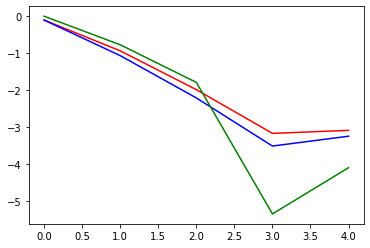

In [33]:
plt.plot(ts, estimated_x1_ekf, 'r-')
plt.plot(ts, estimated_x1_ghkf, 'b-')
plt.plot(ts, true_x1, 'g-')
plt.show()

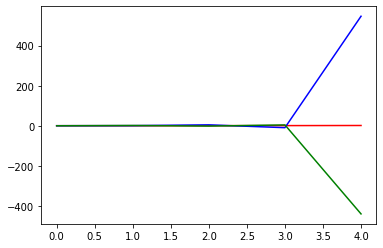

In [34]:
plt.plot(ts, estimated_x2_ekf, 'r-')
plt.plot(ts, estimated_x2_ghkf, 'b-')
plt.plot(ts, true_x2, 'g-')
plt.show()

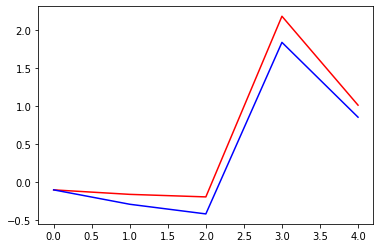

In [35]:
plt.plot(ts, estimated_x1_ekf - true_x1_array, 'r-')
plt.plot(ts, estimated_x1_ghkf - true_x1_array, 'b-')
plt.show()